In [17]:
from bs4 import BeautifulSoup
from collections import namedtuple
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import requests
from textwrap import wrap
import great_tables
from great_tables import GT, loc, style, html, md, nanoplot_options

In [117]:
# Define a named tuple to store plot and table outputs
Output = namedtuple('Output', ['plot_output', 'table_output'])

def generate(source, title):
    """
    Reading in the data
    """
    dfs = []

    for i in source:
        response = requests.get(i)
        energy_response = response.text
        soup = BeautifulSoup(energy_response, "html.parser")
        desc = soup.find(id="lblSeriesDescription").get_text()

        for num in range(len(pd.read_html(i))):
            df = pd.read_html(i)[num]
            df["Index"] = i.split("commodity=")[1].split("&")[0].title()
            df["Description"] = desc
            df["url_name"] = f"[{df['Index'][0]}]({i})"
            dfs.append(df)    

    df = pd.concat(dfs).loc[:, ["Index", "Month", "Price", "Description", "url_name"]]

    df = (df
          .dropna()
          .assign(Month=lambda df_: pd.to_datetime(df_["Month"], format="%b %Y"),
                  Full_Desc=lambda df_: df_["Index"] + ":\n" + df_["Description"])
         )
    
    """
    Calculating the layout
    """
    def layout_calc(source):
      # Layouts
      layout22 = """
        AB
        CD
        """

      layout3 = """
        ABC
        """

      layout2 = """
        AB
        """

      if len(source) == 4:
        return layout22
      elif len(source) == 3:
        return layout3
      elif len(source) == 2:
        return layout2
      
    mosaic = layout_calc(source)
    
    """
    Creating the plot
    """

    line_colour = "#1f77b4"

    def units(x, pos):
        if x >= 1000:
            return f'${x/1000:1.1f}K'
        else:
            return f'${x:1.1f}'
        
    indexes = df["Full_Desc"].drop_duplicates().to_list()

    fig_height = (len(source) / 2 ) * 3

    fig = plt.figure(layout="constrained", figsize=(8, fig_height))
    axd = fig.subplot_mosaic(mosaic)

    plots = [i for i in mosaic.strip().replace("\n", "").replace(" ", "")]

    for index, plot in zip(indexes, plots):
        data = df.query("Full_Desc == @index")
        line = axd[plot].plot(data["Month"], data["Price"], color=line_colour)
        axd[plot].set_title('\n'.join(wrap(index, 40)), fontdict={"fontsize": 8})
        
        axd[plot].yaxis.set_major_locator(plt.MaxNLocator(5))
        axd[plot].yaxis.set_major_formatter(units)

        axd[plot].xaxis.set_major_locator(plt.MaxNLocator(8))
        axd[plot].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
        
        axd[plot].tick_params(axis="x", labelrotation=45)
        axd[plot].tick_params(axis="both", labelsize=8)
        axd[plot].spines["top"].set_visible(False)
        axd[plot].spines["right"].set_visible(False)
        axd[plot].grid(axis="y", linestyle="dotted")
        

    fig.tight_layout(pad=4.0)
    
    plt.figtext(0.07, 0.94, 
                f"{title}, prior 24 months", 
                fontsize=14, ha="left",
                # fontdict={'fontname': 'Georgia'}
                )

    plt.figtext(0.07, 0.06, 
                "Data source: Index Mundi - https://www.indexmundi.com/commodities/",
                fontsize=7, ha='left', 
                fontdict={"color": "grey"})
    
    """
    Creating the table
    """
    index_count = df.drop_duplicates(subset="Index").loc[:,["Index"]].count().values[0]
    max_date = df["Month"].max().strftime("%b-%y")
    min_date = df["Month"].min().strftime("%b-%y")

    nano = (df
            .sort_values("Month")
            .assign(Month=lambda df_: df_["Month"].dt.strftime("%y-%m"))
            .pivot(index="Index", columns="Month", values="Price")
            .assign(Trend=lambda df_: df_.map(lambda x: str(x)).apply(lambda row: ' '.join(map(str, row)), axis=1))
            .reset_index().loc[:, ["Index", "Trend"]]
           )

    gt_tbl = (pd.concat([df.sort_values("Month").head(index_count), df.sort_values("Month").tail(index_count)])
              .sort_values("Month", ascending=False)
              .assign(Month=lambda df_: df_["Month"].dt.strftime("%b-%y"))
              .pivot(index=["url_name", "Index"], columns="Month", values="Price").reset_index()
              .assign(Difference=lambda df_: df_[min_date] - df_[max_date])
              .assign(Difference_pct=lambda df_: ((df_[max_date] - df_[min_date]) / df_[min_date]))
              .rename(columns={"Difference": "Act Difference", "Difference_pct": "% Difference"})
              .merge(nano, left_on="Index", right_on="Index")
              .loc[:, ["url_name", min_date, max_date, "Act Difference", "% Difference", "Trend"]]
              .rename(columns={"url_name": "Index"})
             )

    source_note_html = """
        <style>p {text-align: right;}</style>
        <p>Source: IndexMundi (<a href="https://www.indexmundi.com/commodities/">https://www.indexmundi.com/commodities/</a>)</p>
    """

    tbl = (GT(gt_tbl)
           .tab_header(
               title=f"{title}, {min_date} to {max_date}"
           )
           .cols_label(Index=md("**Index**"), **{col: md(f'**<center>{col}</center>**') for col in gt_tbl.columns[1:]})
           .cols_align(align="center", columns=[min_date, max_date, "Act Difference", "% Difference"])
           .fmt_nanoplot(columns="Trend", reference_line="mean",
                         options=nanoplot_options(
                             data_line_stroke_color="#023047",
                             data_point_stroke_color="#023047",
                             data_point_fill_color="white",
                             data_area_fill_color=line_colour,
                             vertical_guide_stroke_color=line_colour
                         ))
           .fmt_markdown(columns="Index")
           .fmt_currency(columns=[min_date, max_date, "Act Difference"], currency="USD")
           .fmt_percent(columns="% Difference", decimals=2)
           .tab_source_note(source_note=html(source_note_html))
          )

    plot_output = fig
    table_output = tbl.as_raw_html()
    
    return Output(plot_output=plot_output, table_output=table_output)

In [118]:
energy = [  "https://www.indexmundi.com/commodities/?commodity=diesel&months=24",
            "https://www.indexmundi.com/commodities/?commodity=crude-oil&months=24",
            "https://www.indexmundi.com/commodities/?commodity=gasoline&months=24",
            "https://www.indexmundi.com/commodities/?commodity=natural-gas&months=24"]

veg_oils = ["https://www.indexmundi.com/commodities/?commodity=coconut-oil&months=24",
            "https://www.indexmundi.com/commodities/?commodity=palm-oil&months=24",
            "https://www.indexmundi.com/commodities/?commodity=rapeseed-oil&months=24",
            "https://www.indexmundi.com/commodities/?commodity=soybean-oil&months=24"]

raw_agg = ["https://www.indexmundi.com/commodities/?commodity=plywood&months=24",
           "https://www.indexmundi.com/commodities/?commodity=soft-logs&months=24"]


/tmp/ipykernel_13849/1039762936.py:97: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=4.0)


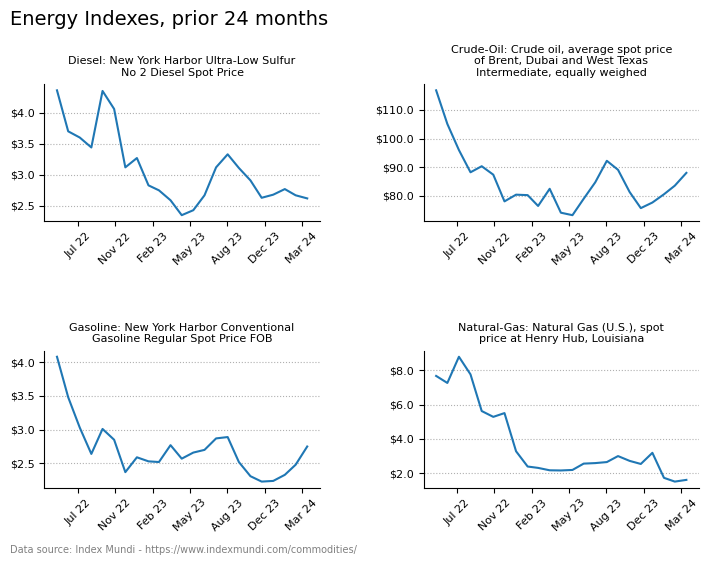

In [119]:
energy_output = generate(energy, "Energy Indexes")

/tmp/ipykernel_13849/1039762936.py:97: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=4.0)


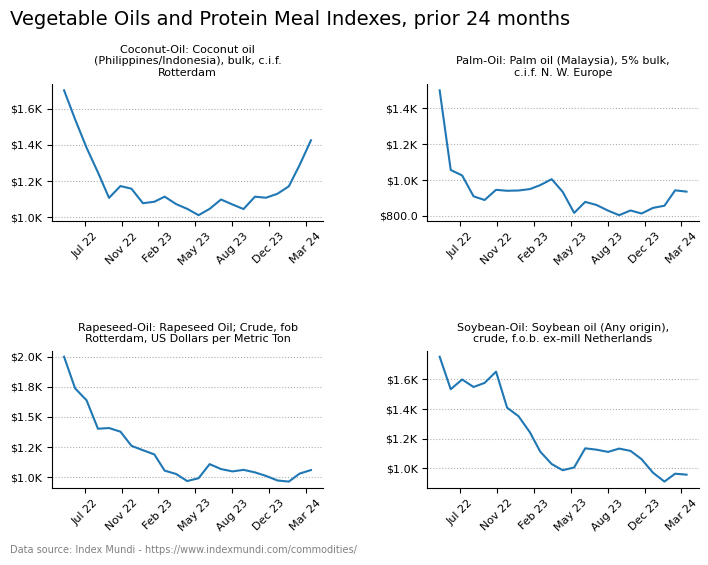

In [120]:
veg_output = generate(veg_oils, "Vegetable Oils and Protein Meal Indexes")

/tmp/ipykernel_13849/1039762936.py:97: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=4.0)


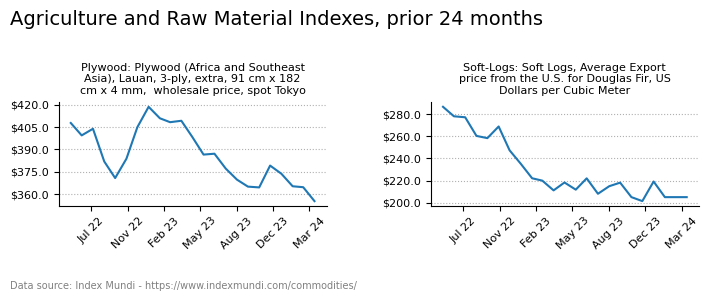

In [121]:
agg_output = generate(raw_agg, "Agriculture and Raw Material Indexes")

In [122]:
from pathlib import Path

import pandas as pd

import pydfy.models as pf

In [149]:
pf.PDF(
  [
    pf.Title('', col_span=2),
    pf.Paragraph(f'<img class="logo-img" src="{Path.cwd() / 'logo.png'}" />'),
  ],
  pf.Title('<h1 class="main-title">Market Intelligence<br>Cost Drivers Report<br>Jul-24</h1>'),
  pf.Paragraph(f'<img class="titlepage-img" src="{Path.cwd() / 'titlepage-img.jpg'}" />'),
  pf.PageBreak,

  [
    pf.Title('Market Indexes, Mundi - prior 2 year trends', col_span=2),
    pf.Paragraph(f'<img class="logo-img" src="{Path.cwd() / 'logo.png'}" />'),
  ],
  pf.Figure(energy_output.plot_output),
  pf.Paragraph(energy_output.table_output),
  
  pf.PageBreak,

  [
    pf.Title('', col_span=2),
    pf.Paragraph(f'<img class="logo-img" src="{Path.cwd() / 'logo.png'}" />'),
  ],
  pf.Figure(veg_output.plot_output),
  pf.Paragraph(veg_output.table_output),

  pf.PageBreak,

  [
    pf.Title('', col_span=2),
    pf.Paragraph(f'<img class="logo-img" src="{Path.cwd() / 'logo.png'}" />'),
  ],
  pf.Figure(agg_output.plot_output),
  pf.Paragraph(agg_output.table_output),
).render(out="market intelligence.pdf", css="style.css")

Error terminating service process.
Traceback (most recent call last):
  File "/home/david/Documents/Projects/pydfy-project/venv/lib/python3.12/site-packages/selenium/webdriver/common/service.py", line 170, in _terminate_process
    self.process.terminate()
  File "/usr/lib/python3.12/subprocess.py", line 2211, in terminate
    self.send_signal(signal.SIGTERM)
  File "/usr/lib/python3.12/subprocess.py", line 2203, in send_signal
    os.kill(self.pid, sig)
PermissionError: [Errno 13] Permission denied
